In [207]:
import os
from pathlib import Path
import requests
import tarfile
from tqdm import tqdm
import json
import numpy as np
import shutil
import pandas as pd
import librosa
import librosa.display
import sounddevice as sd
sd.default.samplerate = 16000
import soundfile as sf
import torch
import torch.utils.data as td
from mlp64 import data
from mlp64 import st
import torchaudio as ta
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from IPython.display import Audio

import scipy.fft as spfft
librosa.set_fftlib(spfft)

pd.set_option('display.max_columns', 30)

In [68]:
sr = 16000
n_fft = 512
hop_length = 64
bpo = 60
n_bins = 400

cqt = lambda y: np.abs(librosa.cqt(y, sr=sr, hop_length=hop_length, n_bins=n_bins, bins_per_octave=bpo))
ms = ta.transforms.MelSpectrogram(n_fft=800, hop_length=160)
s = lambda y: torch.as_tensor(np.log1p(np.abs(librosa.stft(y, n_fft=n_fft, hop_length=hop_length))))
transform = s

In [69]:
path = Path("/home/tim/Desktop/MLP64/dataset/nsynth-test/")
vdf = data.create_dataset_df(path / "examples.json")
target = "instrument_family"
trdf, tedf = data.get_train_test(vdf, target)
trds = data.CachedNSynth(path / "audio", trdf, target_field=target, transform=transform)
teds = data.CachedNSynth(path / "audio", tedf, target_field=target, transform=transform)

batch_size = 32
trloader = td.DataLoader(trds, batch_size=batch_size, num_workers=6, shuffle=True)
teloader = td.DataLoader(teds, batch_size=batch_size, num_workers=6)

JSON loaded into DataFrame!


In [70]:
files = data.dftostr(vdf)

In [71]:
scontent = 'keyboard_acoustic_004-079-127.wav'
sstyle = 'brass_acoustic_046-059-075.wav'
others = ['bass_electronic_018-022-100.wav', 'flute_acoustic_002-107-100.wav']

In [72]:
npdata = data.load_files(path / "audio", [scontent, sstyle] + others)

In [199]:
style_spec = transform(librosa.load("../baselines/keys_5n.wav", sr=16000)[0])[None, :]

In [152]:
content = torch.from_numpy(npdata[:, 0])
style = torch.from_numpy(npdata[:, 1])
sd.play(style)

content_spec = transform(npdata[:, 0])#.cuda()
style_spec = transform(npdata[:, 1])#.cuda()

In [153]:
content_spec = content_spec.reshape(1, *content_spec.shape)
style_spec = style_spec.reshape_as(content_spec)

In [200]:
cuda = True
style_torch = style_spec.cuda()

In [201]:
num_epochs = 10000

noise = torch.rand(style_torch.shape, device="cuda" if cuda else None, requires_grad=True)
optimizer = torch.optim.Adam([noise])
learning_rate_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs,
                                                                            eta_min=0.00002)

In [202]:
def spectrum2wav(spectrum, sr, n_fft, hop_length):
    # Return the all-zero vector with the same shape of `a_content`
    a = np.exp(spectrum) - 1
    p = 2 * np.pi * np.random.random_sample(spectrum.shape) - np.pi
    for i in range(50):
        S = a * np.exp(1j * p)
        x = librosa.istft(S, hop_length=hop_length)
        p = np.angle(librosa.stft(x, n_fft, hop_length=hop_length))
    return x

In [203]:
def compute_content_loss(a_C, a_G):
    """
    Compute the content cost
    Arguments:
    a_C -- tensor of dimension (1, n_C, n_H, n_W)
    a_G -- tensor of dimension (1, n_C, n_H, n_W)
    Returns:
    J_content -- scalar that you compute using equation 1 above
    """
    m, n_C, n_H, n_W = a_G.shape

    # Reshape a_C and a_G to the (m * n_C, n_H * n_W)
    a_C_unrolled = a_C.view(m * n_C, n_H * n_W)
    a_G_unrolled = a_G.view(m * n_C, n_H * n_W)

    # Compute the cost
    J_content = 1.0 / (4 * m * n_C * n_H * n_W) * torch.sum((a_C_unrolled - a_G_unrolled) ** 2)

    return J_content


def gram(A):
    """
    Argument:
    A -- matrix of shape (n_C, n_L)
    Returns:
    GA -- Gram matrix of shape (n_C, n_C)
    """
    GA = torch.matmul(A, A.t())

    return GA


def gram_over_time_axis(A):
    """
    Argument:
    A -- matrix of shape (1, n_C, n_H, n_W)
    Returns:
    GA -- Gram matrix of A along time axis, of shape (n_C, n_C)
    """
    m, n_C, n_H, n_W = A.shape

    # Reshape the matrix to the shape of (n_C, n_L)
    # Reshape a_C and a_G to the (m * n_C, n_H * n_W)
    A_unrolled = A.view(m * n_C, n_H * n_W)
    GA = torch.matmul(A_unrolled, A_unrolled.t())

    return GA


lossf = torch.nn.MSELoss()
def compute_layer_style_loss(a_S, a_G):
    """
    Arguments:
    a_S -- tensor of dimension (1, n_C, n_H, n_W)
    a_G -- tensor of dimension (1, n_C, n_H, n_W)
    Returns:
    J_style_layer -- tensor representing a scalar style cost.
    """

    # Reshape the matrix to the shape of (n_C, n_L)
    # Reshape a_C and a_G to the (m * n_C, n_H * n_W)

    # Calculate the gram
    # !!!!!! IMPORTANT !!!!! Here we compute the Gram along n_C,
    # not along n_H * n_W. But is the result the same? No.
    GS = st.GramMatrix()(a_S)
    GG = st.GramMatrix()(a_G)

    # Computing the loss

    return GS.numel() * lossf(GS, GG) / torch.sum(GG**2)

In [209]:
sl = st.StyleLoss(style_torch)
al = st.AutoLoss(style_torch, 1000, bounds=(0, np.inf))
dl = st.DivLoss(style_torch, 1)

for epoch in range(1, num_epochs + 1):
    optimizer.zero_grad()
    #it = model(noise)
    #content_loss = content_param * compute_content_loss(c, it)
    #style_loss = style_param * compute_layer_style_loss(style_torch, noise)
    #style_loss = compute_layer_style_loss(style_torch, noise)
    style_loss = sl(noise)
    ac_loss = al(noise)
    div_loss = dl(noise)
    loss = sl(noise) + al(noise)# + dl(noise)
    loss.backward()
    optimizer.step()
    learning_rate_scheduler.step()

    # print
    if epoch % print_every == 0:
        print("{} {}% style_loss:{:4f} total_loss:{:4f}".format(epoch, epoch / num_epochs * 100, style_loss.item(), loss.item()))
        current_loss += loss.item()

    # Add current loss avg to list of losses
    if epoch % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

gen_spectrum = noise.cpu().data.numpy().squeeze()

1000 10.0% style_loss:0.122503 total_loss:1.909827
2000 20.0% style_loss:0.119035 total_loss:1.493011
3000 30.0% style_loss:0.111328 total_loss:0.840274
4000 40.0% style_loss:0.097674 total_loss:0.409221
5000 50.0% style_loss:0.077483 total_loss:0.198436
6000 60.0% style_loss:0.059567 total_loss:0.109621
7000 70.0% style_loss:0.047876 total_loss:0.074198
8000 80.0% style_loss:0.038727 total_loss:0.057591
9000 90.0% style_loss:0.032653 total_loss:0.048426
10000 100.0% style_loss:0.029690 total_loss:0.043622


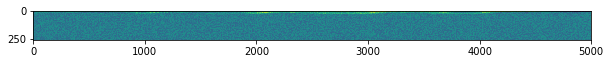

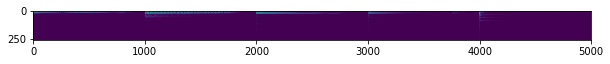

In [205]:
gen_spectrum = noise.cpu().data.numpy().squeeze()
plt.figure(figsize=(10, 5))
plt.imshow(gen_spectrum)
plt.figure(figsize=(10, 5))
plt.imshow(style_spec.squeeze())

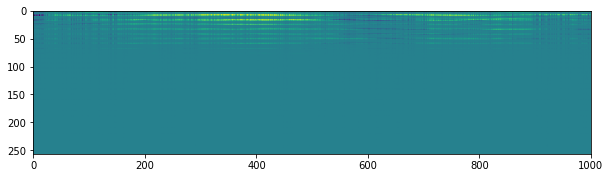

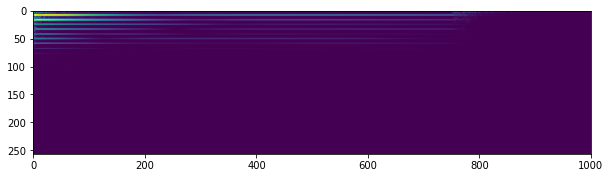

In [191]:
gen_spectrum = noise.cpu().data.numpy().squeeze()
plt.figure(figsize=(10, 5))
plt.imshow(gen_spectrum)
plt.figure(figsize=(10, 5))
plt.imshow(style_spec.squeeze())

In [206]:
#out = librosa.feature.inverse.mel_to_audio(gen_spectrum, sr, 800, 160)
out = spectrum2wav(gen_spectrum, sr, n_fft, hop_length)
sd.play(out)

In [208]:
sf.write("scarynoise.wav", out, samplerate=16000)

In [187]:
sd.play(content)

In [186]:
sd.play(style)

In [15]:
a = np.ones((1, 10, 1, 11))

In [16]:
from torch import nn

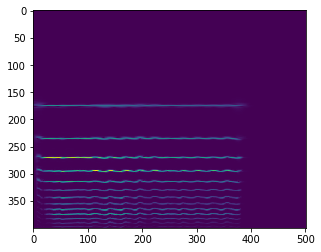

In [46]:
plt.imshow(style_spec)

In [319]:
a = style_spec[None, :, None, :]
a2 = torch.from_numpy(style_spec)
print(a2.shape)

_, n_fft_bins,_,n_frames = a.shape
n_filters = 128
kernel_size = (1, 3)

a = torch.from_numpy(a)
a.shape

conv = nn.Conv2d(n_fft_bins, n_filters, kernel_size=kernel_size, stride=1, padding=0)
b = conv.forward(a)
b.shape

torch.Size([400, 501])


torch.Size([1, 128, 1, 499])

In [49]:
k2 = (1, 7)
conv2 = nn.Conv2d(b.shape[1], n_filters, kernel_size=k2, stride=2, padding=0)
c = conv2.forward(b)
c.shape

torch.Size([1, 128, 1, 247])

In [21]:
g = GramMatrix()

In [59]:
i = np.complex(1.2, 2)
print(np.sqrt(np.real(i)**2 + np.imag(i)**2))
np.abs(i)

2.33238075793812


2.33238075793812

In [138]:
ccm(np.array([1.2, 2]))

(-2.56, 5.76)

In [189]:
def ac_fft(F_synth, F_target):
    fft_synth = torch.rfft(F_synth, 1)
    fft_target = torch.rfft(F_target, 1)
    # Complex # times its conjugate == a**2+b**2, which is the magnitude squared
    ac_synth = torch.rfft(ta.functional.complex_norm(fft_synth, 2), 1)
    ac_target = torch.rfft(ta.functional.complex_norm(fft_target, 2), 1)
    #return torch.sum((ac_synth - ac_target) ** 2) / (torch.sum(ac_target) ** 2)
    return ac_synth, ac_target


In [335]:
torch.stack((a, torch.zeros_like(a)), 4).shape

torch.Size([1, 400, 1, 501, 2])

In [403]:
np.fft.fft(style_spec, n=2*len(style_)

array([[1.1973477e-03, 1.1972742e-03, 1.1970750e-03, ..., 8.9112669e-05,
        8.7926921e-05, 8.8337292e-05],
       [1.7680025e-03, 1.7678384e-03, 1.7674136e-03, ..., 2.9126223e-04,
        2.9097791e-04, 2.9107751e-04],
       [1.2375675e-03, 1.2374329e-03, 1.2371810e-03, ..., 3.7736123e-04,
        3.7727825e-04, 3.7731923e-04],
       ...,
       [1.6423042e-05, 2.7730004e-05, 5.8310499e-05, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [1.9886349e-05, 2.7647144e-05, 2.9870873e-05, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [1.1938732e-05, 5.9792481e-05, 2.7401526e-05, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00]], dtype=float32)

In [570]:
def ac(x):
    halfn = x.shape[-1]/2
    if np.mod(x.shape[-1], 2) == 0:
        pad = (int(halfn), int(halfn)-1)
    else:
        pad = (int(halfn), int(halfn))
    print("ac", x.shape, pad)
    x = torch.rfft(torch.nn.functional.pad(x, pad), 1, onesided=True)
    c = ta.functional.complex_norm(x, 2)
    print(x.shape, c.shape)
    res = torch.irfft(torch.stack((c, torch.zeros_like(c)), -1), 1, onesided=True)
    print(res[..., :int(halfn*2)].shape)
    return res[..., :int(halfn*2)]


def ac2(x):
    print("ac2", x.shape)
    x = np.fft.fft(x, n= 2 * x.shape[-1] - 1)
    print(np.real(np.fft.ifft(x * np.conj(x)))[:, :int(x.shape[-1] / 2)+ 1].shape)
    return np.real(np.fft.ifft(x * np.conj(x)))[:, :int(x.shape[-1] / 2)+ 1]


def autocorr(x, mode="full"):
    result = np.correlate(x, x, mode=mode)
    print("autocorr", result[int(result.size/2):].shape)
    return result[int(result.size/2):]

In [569]:
torch.zeros([2, 10])

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

autocorr (125,)
ac torch.Size([2, 125]) (62, 62)
torch.Size([2, 125, 2]) torch.Size([2, 125])
torch.Size([2, 125])


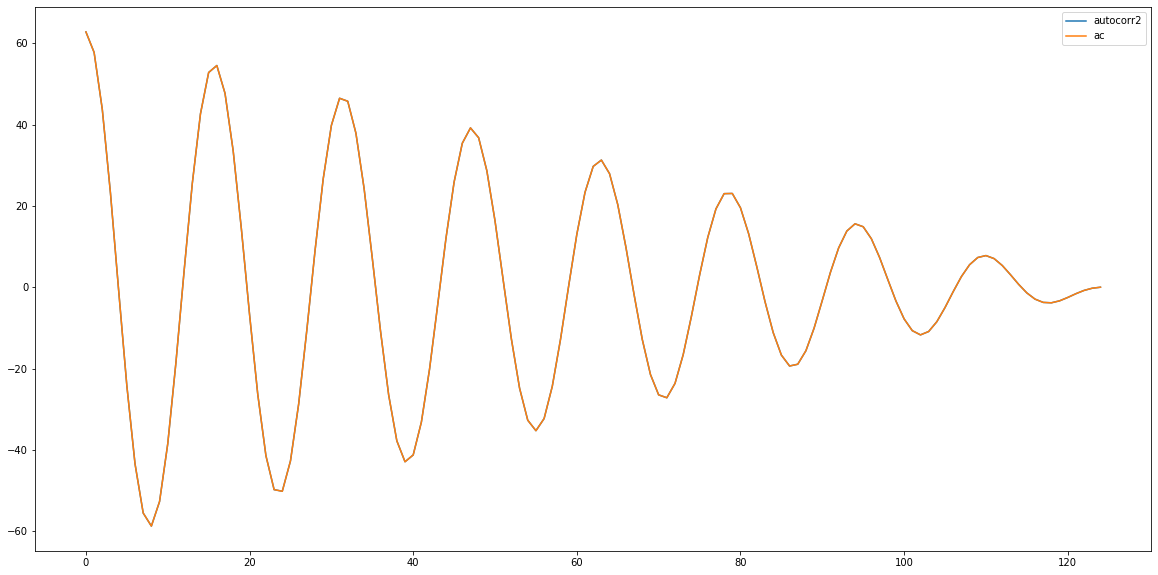

In [553]:
xx = np.stack((x[:-1],x[:-1]))
#xx = np.stack((x,x))
plt.figure(figsize=(20, 10))
#plt.plot(ac2(xx)[0, :], label="np")
#plt.plot(autocorr(xx[0, :]), label="autocorr")
plt.plot(autocorr(xx[1, :], mode="full"), label="autocorr2")
plt.plot(ac(torch.from_numpy(xx)).squeeze()[0, :], label="ac")
plt.legend()

In [417]:
padsize = int(a.shape[-1]/2)
torch.nn.functional.pad(a, (padsize, padsize)).shape

torch.Size([1, 400, 1, 1001])

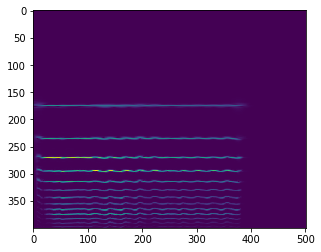

In [421]:
plt.imshow(style_spec)

ac2 (400, 501)
(400, 501)
autocorr (501,)
ac torch.Size([1, 400, 1, 501]) (250, 250)
torch.Size([1, 400, 1, 501, 2]) torch.Size([1, 400, 1, 501])
torch.Size([1, 400, 1, 501])


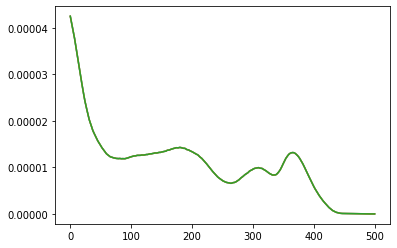

In [571]:
plt.plot(ac2(style_spec)[100, :])
plt.plot(autocorr(style_spec[100, :]))
plt.plot(ac(a).squeeze()[100, :])

torch.Size([1, 400, 1, 1001, 2])
torch.Size([1, 400, 1, 1001])


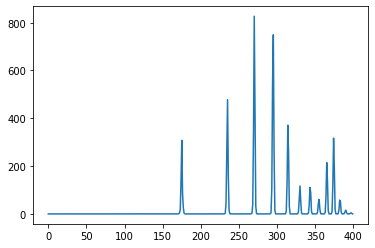

In [401]:
plt.plot(ac(a).squeeze()[:, 55])

In [196]:
import scipy as sp

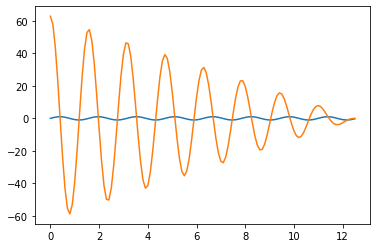

In [290]:
a = 1
f = 4
t = np.arange(0,4*np.pi,0.1)
p = 0.
x = a*np.sin(f*t + p)
plt.plot(t, x)
plt.plot(t, autocorr(x))

(126,)
(251,)


/home/tim/miniconda3/envs/mlp/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/tim/miniconda3/envs/mlp/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


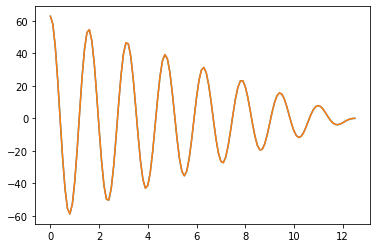

In [374]:
x2 = np.fft.fft(x, n=2*len(x)-1)
y = np.fft.ifft(x2*np.conj(x2))
plt.plot(t, y[:126])
plt.plot(t, ac2(x))
#plt.plot(t, np.abs(y))
#plt.plot(t, sp.signal.correlate(x, x, method='fft')[125:])

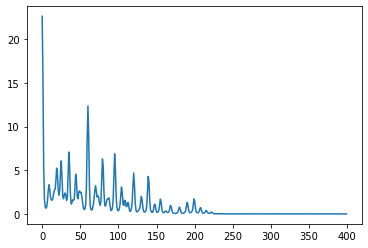

In [424]:
plt.plot(autocorr(style_spec[:, 250]))

In [136]:
def complex_mag(r, i):
    # same as ta.functional.complex_norm
    return torch.sqrt(r**2 + i**2)

def ccm(x):
    r = x[..., 0]
    i = x[..., 1]
    return r**2+i**2

In [110]:
a3 = torch.rfft(a2, 1, onesided=False)
mag = complex_mag(a3[:,:,0], a3[:,:,1])

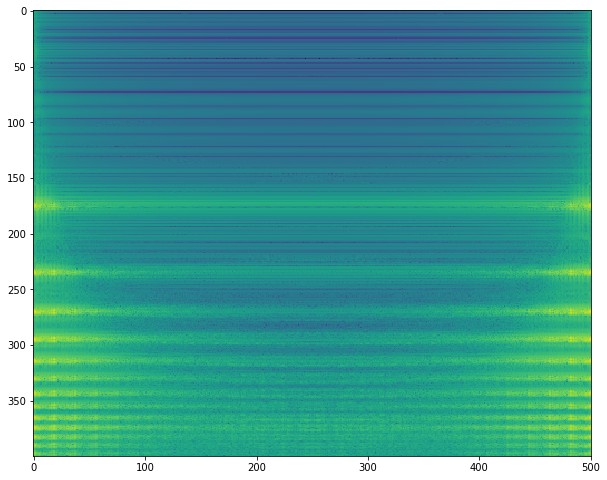

In [127]:
plt.figure(figsize=(10, 10))
plt.imshow(torch.log(ta.functional.complex_norm(a3)))

(400, 501)


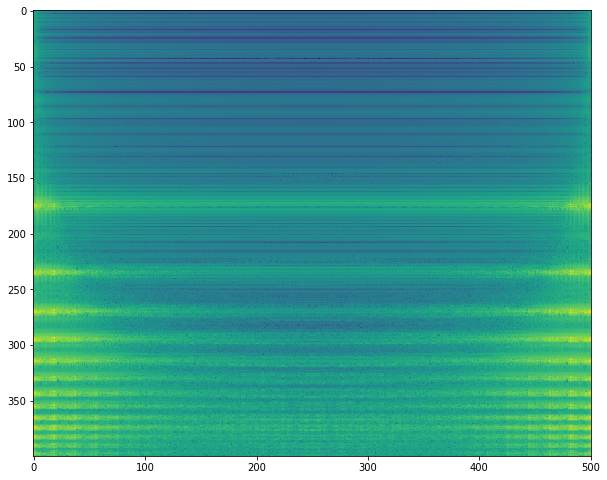

In [115]:
print(style_spec.shape)
plt.figure(figsize=(10, 10))
plt.imshow(np.log(np.abs(np.fft.fft(style_spec, axis=-1))))

In [88]:
a.shape

torch.Size([1, 400, 1, 501])

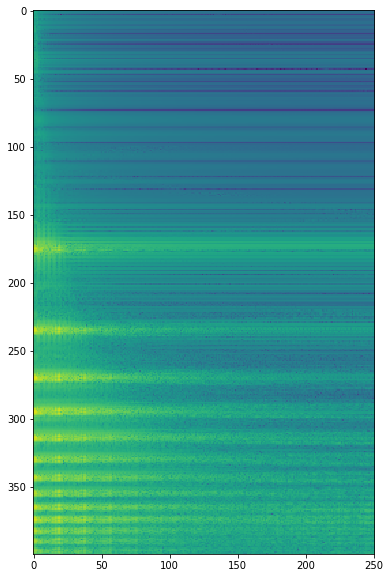

In [97]:
a_fft = torch.rfft(a, 1).squeeze()
plt.figure(figsize=(10, 10))
plt.imshow(torch.log(complex_mag(a_fft[:,:,0], a_fft[:,:,1])))

In [35]:
?torch.irfft

Docstring:
irfft(input, signal_ndim, normalized=False, onesided=True, signal_sizes=None) -> Tensor

Complex-to-real Inverse Discrete Fourier Transform

This method computes the complex-to-real inverse discrete Fourier transform.
It is mathematically equivalent with :func:`ifft` with differences only in
formats of the input and output.

The argument specifications are almost identical with :func:`~torch.ifft`.
Similar to :func:`~torch.ifft`, if :attr:`normalized` is set to ``True``,
this normalizes the result by multiplying it with
:math:`\sqrt{\prod_{i=1}^K N_i}` so that the operator is unitary, where
:math:`N_i` is the size of signal dimension :math:`i`.

.. note::
    Due to the conjugate symmetry, :attr:`input` do not need to contain the full
    complex frequency values. Roughly half of the values will be sufficient, as
    is the case when :attr:`input` is given by :func:`~torch.rfft` with
    ``rfft(signal, onesided=True)``. In such case, set the :attr:`onesided`
    argument of 

In [42]:
torch.irfft(torch.rfft(c, 1), 1)

tensor([[[[ 0.0578,  0.0769,  0.0893,  ...,  0.0287,  0.0287,  0.0287]],

         [[-0.0090, -0.0212, -0.0539,  ...,  0.0067,  0.0067,  0.0067]],

         [[ 0.0312,  0.0253,  0.0370,  ...,  0.0067,  0.0067,  0.0067]],

         ...,

         [[ 0.0183,  0.0243,  0.0041,  ...,  0.0126,  0.0126,  0.0126]],

         [[-0.0527, -0.0603, -0.0604,  ..., -0.0255, -0.0255, -0.0255]],

         [[-0.0051,  0.0037,  0.0048,  ...,  0.0207,  0.0207,  0.0207]]]],
       grad_fn=<ViewBackward>)